In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END

from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list,add_messages]

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")

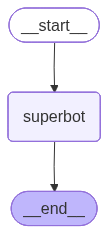

In [5]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

graph = StateGraph(State)

graph.add_node("superbot",superbot)

graph.add_edge(START,"superbot")
graph.add_edge("superbot",END)

graph_builder = graph.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable":{"thread_id":"2"}}

graph_builder.invoke({"messages":"Hi, My name is suresh and I Like Cricket"},config=config)

{'messages': [HumanMessage(content='Hi, My name is suresh and I Like Cricket', additional_kwargs={}, response_metadata={}, id='91c72193-fb46-4bff-a132-f801d5f03be4'),
  AIMessage(content="Hello Suresh, nice to meet you. It's great to hear that you like cricket. Cricket is a fantastic sport with a massive following worldwide, especially in India. Which team or player is your favorite in the Indian Premier League (IPL) or the international cricket team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 46, 'total_tokens': 104, 'completion_time': 0.093291798, 'completion_tokens_details': None, 'prompt_time': 0.002131198, 'prompt_tokens_details': None, 'queue_time': 0.050499912, 'total_time': 0.095422996}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b7a8c-2cff-7500-9290-fcb5fca49621-0', usage_me

#### Streaming 
Methods : .stream() - synchronous & .astream() - async
- used to stream back the results
- Additional Parameters in streaming modes for graph state
- values : streams full state of graph after each node is called
- updates : streams updates to the state of the graph after each node is called.

In [8]:
config = {"configurable":{"thread_id":"123"}}

for chunk in graph_builder.stream({"messages":"I Also Like Football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='I Also Like Football', additional_kwargs={}, response_metadata={}, id='7eff58c1-b20d-4283-b14a-29ade93ef2cf')]}
{'messages': [HumanMessage(content='I Also Like Football', additional_kwargs={}, response_metadata={}, id='7eff58c1-b20d-4283-b14a-29ade93ef2cf'), AIMessage(content="It seems like you also have an interest in football, which could refer to two different sports: American football or association football (soccer). \n\nIf you're referring to American football, which is popular in the United States, are you more interested in the National Football League (NFL), college football, or perhaps high school football?\n\nOn the other hand, if you're referring to association football (soccer), which is popular worldwide, are you more interested in international competitions like the FIFA World Cup, the English Premier League, La Liga, or perhaps the UEFA Champions League?\n\nLet me know, and I can try to have a discussion about your favorite team or pl

In [9]:
for chunk in graph_builder.stream({"messages":"I Love Msdhoni"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='I Also Like Football', additional_kwargs={}, response_metadata={}, id='7eff58c1-b20d-4283-b14a-29ade93ef2cf'), AIMessage(content="It seems like you also have an interest in football, which could refer to two different sports: American football or association football (soccer). \n\nIf you're referring to American football, which is popular in the United States, are you more interested in the National Football League (NFL), college football, or perhaps high school football?\n\nOn the other hand, if you're referring to association football (soccer), which is popular worldwide, are you more interested in international competitions like the FIFA World Cup, the English Premier League, La Liga, or perhaps the UEFA Champions League?\n\nLet me know, and I can try to have a discussion about your favorite team or player!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 39, 'total_tokens': 174, 'completion_tim

#### Streaming responses with astream method
**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [12]:
config = {"configurable":{
    "thread_id":"1234"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is suresh and I Like to Play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is suresh and I Like to Play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019b7a95-86be-7e43-8db4-33530e8b3664', 'metadata': {'thread_id': '1234'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is suresh and I Like to Play cricket', additional_kwargs={}, response_metadata={}, id='3407afa7-9d62-4630-8caa-fd6576f8a69c')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': '019b7a95-86c1-7630-8128-a8157f4c01f6', 'metadata': {'thread_id': '1234', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:bc203a5e-814b-de70-a29e-61ee686a13e4'}, 'parent_ids': ['019b7a95-86be-7e43-8db4-33530e8b3664']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is suresh and I Li